In [1]:
!pip install stable-baselines3 gymnasium JaxFin scienceplots

In [2]:
!pip install sbx-rl

In [3]:
# @title Imports
# @markdown Do you want to save the model?
from abc import ABCMeta, abstractmethod
from itertools import product

import numpy as np
from numpy.random import choice

from gymnasium import Env, spaces
from gymnasium.spaces import Box, Discrete
from gymnasium.wrappers import NormalizeObservation
from google.colab import drive

from jax import vmap

from jaxfin.price_engine.black_scholes import european_price, delta_european
from jaxfin.models.gbm import UnivGeometricBrownianMotion

import matplotlib.pyplot as plt

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecMonitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from sbx import TD3
import scienceplots

import pprint

import torch as th

SEED: int = 0
SAVE: bool = True # @param ["False", "True"] {type:"raw"}

plt.style.use(['science','no-latex'])
np.random.seed(SEED)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


## BS environment


In [4]:
v_delta_european = vmap(delta_european, in_axes=(0, None, None, None, None))


def flatten(fn):
    def wrapper(*args, **kwargs):
        return fn(*args, **kwargs).flatten()

    return wrapper


class HedgingEnvBase(Env):
    metadata = {"render.modes": ["human"]}
    action_space: spaces.Space
    observation_space: spaces.Space

    __metaclass__ = ABCMeta

    def __init__(
        self,
        s0: float,
        strike: float,
        expiry: float,
        r: float,
        mu: float,
        sigma: float,
        n_steps: int,
    ):
        self.s0 = s0
        self.strike = strike
        self.expiry = expiry
        self.r = r
        self.mu = mu
        self.sigma = sigma
        self.n_steps = n_steps
        self.dt = expiry / n_steps
        self._current_step = 0

        self.render_mode = "human"

        self._stock_path = np.array([])
        self._call_prices = np.array([])
        self._deltas = np.array([])

        self._current_pnl = 0.0
        self._hedging_portfolio_value = 0.0
        self._current_hedging_delta = 0.0
        self._previous_hedging_delta = 0.0
        self._back_account_value = 0.0
        self._ddelta = 0.0

        self._epsilon = 1
        self._lambda = 0.1
        self._tick_size = 0.00

    def reset(self, seed=None):
        super().reset(seed=seed)

        self._current_step = 0
        self._current_pnl = 0.0
        self._stock_path = self._generate_stock_path(seed=seed)
        self._call_prices = self._get_call_prices()
        self._deltas = self._get_deltas()
        self._hedging_portfolio_value = self._call_prices[0]
        self._current_hedging_delta = -self._deltas[0]
        self._back_account_value = -(
            self._hedging_portfolio_value + self.current_hedging_delta * self.s0
        )

        observations = self._get_observations()
        infos = self._get_infos()

        return observations, infos

    def step(self, action: float):
        self._current_step += 1

        done = self._current_step == (self.n_steps - 1)
        reward = self._calculate_reward()

        self._hedging_portfolio_value = self._calculate_hedging_portfolio_value(action)

        observations = self._get_observations()
        infos = self._get_infos()
        self._update_delta(action)

        return observations, reward, done, False, infos

    def render(self, mode="human"):
        pass

    def _update_delta(self, new_delta: float):
        self._ddelta = new_delta - self.current_hedging_delta
        self._previous_hedging_delta = self.current_hedging_delta
        self.current_hedging_delta = new_delta

    def _calculate_reward(self) -> float:
        pnl = self._calculate_pnl()
        self._current_pnl = pnl
        return pnl - self._lambda / 2 * pnl**2

    def _calculate_pnl(self) -> float:
        dv = (
            self._call_prices[self._current_step]
            - self._call_prices[self._current_step - 1]
        )
        ds = (
            self._stock_path[self._current_step]
            - self._stock_path[self._current_step - 1]
        )[0]
        ddelta = self._ddelta

        return (
            dv + self.current_hedging_delta * ds - self._get_transaction_costs(ddelta)
        )

    def _get_transaction_costs(self, ddelta: float):
        return self._epsilon * self._tick_size * (np.abs(ddelta) + 0.01 * ddelta**2)

    def _get_observations(self):
        log_price_strike = self._get_log_ratio()
        time_to_expiration = self.expiry
        bs_delta = self._deltas[self._current_step]
        call_price = self._call_prices[self._current_step]
        return np.asarray(
            [
                log_price_strike,
                self._get_current_stock_vol(self._current_step),
                time_to_expiration,
                bs_delta,
                call_price / self._call_prices[0],
                self.current_hedging_delta,
            ],
            dtype=np.float32,
        )

    def _get_infos(self):
        return {
            "price": self._call_prices[self._current_step],
            "time_to_expiration": self.expiry - self._current_step * self.dt,
            "bs_delta": self._deltas[self._current_step],
            "stock_price": self._get_current_stock_price(),
            "current_delta": self.current_hedging_delta,
            "log(S/K)": self._get_log_ratio(),
            "hedge_portfolio_value": self._hedging_portfolio_value,
            "bank_account": self._back_account_value,
            "current_pnl": self._current_pnl,
        }

    @property
    def current_hedging_delta(self):
        return self._current_hedging_delta

    @current_hedging_delta.setter
    def current_hedging_delta(self, new_hedge: float):
        self._current_hedging_delta = new_hedge

    def _get_log_ratio(self):
        if self._current_step == -1:
            return np.log(self.s0 / self.strike)
        return np.log(self._stock_path[self._current_step, 0] / self.strike)

    @abstractmethod
    def _get_current_stock_vol(self, step: int) -> float:
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def _generate_stock_path(self, seed=None) -> np.ndarray:
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def _get_call_prices(self) -> np.ndarray:
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def _get_deltas(self) -> np.ndarray:
        raise NotImplementedError("Subclasses must implement this method")

    def _calculate_hedging_portfolio_value(self, new_delta: float):
        new_hedging_port_value = (
            self._back_account_value
            + self._current_hedging_delta * self._get_current_stock_price()
        )
        self._back_account_value = (
            new_hedging_port_value - new_delta * self._get_current_stock_price()
        )

        return -new_hedging_port_value

    def _get_current_stock_price(self):
        return self._stock_path[self._current_step, 0]


class BlackScholesEnvBase(HedgingEnvBase):
    metadata = {"render.modes": ["human"]}
    action_space: spaces.Space
    observation_space: spaces.Space

    def __init__(
        self,
        s0: float,
        strike: float,
        expiry: float,
        r: float,
        mu: float,
        sigma: float,
        n_steps: int,
    ):
        super().__init__(
            s0=s0,
            strike=strike,
            expiry=expiry,
            r=r,
            mu=mu,
            sigma=sigma,
            n_steps=n_steps,
        )

    def _generate_stock_path(self, seed=None) -> np.ndarray:
        if seed:
            seed = 0

        gbm = UnivGeometricBrownianMotion(self.s0, self.mu, self.sigma)

        return np.asarray(gbm.sample_paths(self.expiry, self.n_steps, 1))

    def _get_current_stock_vol(self, step: int) -> float:
        return self.sigma

    @flatten
    def _get_call_prices(self) -> np.ndarray:
        return np.asarray(
            [
                european_price(
                    self._stock_path[i],
                    self.strike,
                    self.expiry - i * self.dt,
                    self.sigma,
                    self.r,
                )
                for i in range(self.n_steps)
            ]
        )

    @flatten
    def _get_deltas(self) -> np.ndarray:
        return np.asarray(
            [
                v_delta_european(
                    self._stock_path[i],
                    self.strike,
                    self.expiry - i * self.dt,
                    self.sigma,
                    self.r,
                )
                for i in range(self.n_steps)
            ]
        )


class BlackScholesEnvCont(BlackScholesEnvBase):

    def __init__(
        self,
        s0: float,
        strike: float,
        expiry: float,
        r: float,
        mu: float,
        sigma: float,
        n_steps: int,
    ):
        super().__init__(
            s0=s0,
            strike=strike,
            expiry=expiry,
            r=r,
            mu=mu,
            sigma=sigma,
            n_steps=n_steps,
        )
        self.action_space = Box(low=-1.0, high=0.0, shape=(1,))
        self.observation_space = Box(
            low=np.array([-np.inf, 0.0, 0.0, 0.0, 0.0, -1.0], dtype=np.float32),
            high=np.array([np.inf, 2.0, np.inf, 1.0, np.inf, 1.0], dtype=np.float32),
            shape=(6,),
        )

    def step(self, action: np.ndarray):
        new_hedge = action[0]
        return super().step(new_hedge)


class BlackScholesEnvDis(BlackScholesEnvBase):

    def __init__(
        self,
        s0: float,
        strike: float,
        expiry: float,
        r: float,
        mu: float,
        sigma: float,
        n_steps: int,
    ):
        super().__init__(
            s0=s0,
            strike=strike,
            expiry=expiry,
            r=r,
            mu=mu,
            sigma=sigma,
            n_steps=n_steps,
        )
        self.action_space = Discrete(100)
        self.observation_space = Box(
            low=np.array([-np.inf, 0.0, 0.0, 0.0, 0.0, -1.0], dtype=np.float32),
            high=np.array([np.inf, 2.0, np.inf, 1.0, np.inf, 1.0], dtype=np.float32),
            shape=(6,),
        )

    def step(self, action: float):
        return super().step(-(action / 100))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
check_env(BlackScholesEnvCont(100, 100, 1.0, 0.0, 0.0, 0.2, 252))

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


## T3D

In [6]:
expires = [0.25, 0.5, 1.0, 2.0]
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]
n_steps = [63, 126, 252, 504]

cartesian_product = list(product(expires, sigmas, n_steps))

In [7]:
indexes = choice(np.asarray(range(len(cartesian_product))), 79, replace=False)
random_sample = np.asarray(cartesian_product)[indexes]

In [8]:
r = 0.0
mu = 0.0

init_s0 = 100
s0 = init_s0
init_K = 100
init_T = 1.0
init_vol = 0.2
init_n_steps = 252

n_episodes = 100

In [9]:
def make_env(s0, strike, expiry, r, mu, vol, n_steps):
    def _create_env():
        return BlackScholesEnvCont(s0, strike, expiry, r, mu, vol, n_steps)
    return _create_env

def make_vec_env(s0: float, strike: float, expiry:float, r: float, mu: float, vol: float, n_steps: int) -> Env:
    vec_env = DummyVecEnv([make_env(s0, strike, expiry, r, mu, vol, n_steps) for _ in range(5)])
    return VecMonitor(vec_env, info_keywords=("current_pnl",), filename='./training.log')

In [10]:
initial_env = make_vec_env(init_s0, init_K, init_T, r, mu, init_vol, init_n_steps)

In [11]:
learning_rate = 0.0005
batch_size = 128
gamma = 0.9999
train_freq = 100
policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[64, 64]))

model = TD3("MlpPolicy",
             initial_env,
             learning_rate=learning_rate,
             batch_size=batch_size,
             gamma=gamma,
             train_freq=train_freq,
             policy_kwargs=policy_kwargs,
             verbose=0)

## Training

In [12]:
model.learn(total_timesteps=252*n_episodes, log_interval=10, progress_bar=True)

Output()

In [13]:
training_rewards = [evaluate_policy(model, initial_env, n_eval_episodes=10)[0]]

In [14]:
# train loop
for T, vol, steps in random_sample:
    n_steps = int(steps)
    K = np.random.randint(low=int(s0 * 0.8), high=int(s0 * 1.2))
    print(f's0: {s0}, K: {K}, T: {T}, vol: {vol}, steps: {steps}')
    env = make_vec_env(s0, K, T, r, mu, vol, n_steps)
    model.set_env(env)
    model.learn(total_timesteps=n_steps*n_episodes, log_interval=10, progress_bar=True)
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    training_rewards.append(mean_reward)
    print(f'Training reward: {mean_reward}')

s0: 100, K: 98, T: 0.25, vol: 0.4, steps: 126.0


Output()

Training reward: -0.4589434564113617
s0: 100, K: 94, T: 0.25, vol: 0.3, steps: 504.0


Output()

Training reward: 0.6087982058525085
s0: 100, K: 118, T: 2.0, vol: 0.2, steps: 126.0


Output()

Training reward: -0.20271730422973633
s0: 100, K: 105, T: 2.0, vol: 0.2, steps: 252.0


Output()

Training reward: -2.5315604209899902
s0: 100, K: 117, T: 1.0, vol: 0.2, steps: 504.0


Output()

Training reward: 0.3038598597049713
s0: 100, K: 87, T: 1.0, vol: 0.4, steps: 252.0


Output()

Training reward: -3.765209197998047
s0: 100, K: 98, T: 1.0, vol: 0.4, steps: 504.0


Output()

Training reward: -3.771925687789917
s0: 100, K: 109, T: 0.25, vol: 0.1, steps: 252.0


Output()

Training reward: -1.1350255012512207
s0: 100, K: 81, T: 1.0, vol: 0.2, steps: 252.0


Output()

Training reward: -13.016634941101074
s0: 100, K: 89, T: 0.25, vol: 0.5, steps: 504.0


Output()

Training reward: -6.956539154052734
s0: 100, K: 98, T: 0.5, vol: 0.5, steps: 504.0


Output()

Training reward: -11.714517593383789
s0: 100, K: 82, T: 1.0, vol: 0.1, steps: 126.0


Output()

Training reward: -5.181368350982666
s0: 100, K: 109, T: 1.0, vol: 0.3, steps: 252.0


Output()

Training reward: 0.33142322301864624
s0: 100, K: 107, T: 0.25, vol: 0.1, steps: 504.0


Output()

Training reward: -0.2220856249332428
s0: 100, K: 119, T: 1.0, vol: 0.3, steps: 63.0


Output()

Training reward: -0.2867736220359802
s0: 100, K: 88, T: 0.25, vol: 0.4, steps: 63.0


Output()

Training reward: -6.018503665924072
s0: 100, K: 87, T: 0.25, vol: 0.5, steps: 252.0


Output()

Training reward: -7.749381065368652
s0: 100, K: 106, T: 0.5, vol: 0.5, steps: 126.0


Output()

Training reward: -5.643004417419434
s0: 100, K: 92, T: 2.0, vol: 0.3, steps: 252.0


Output()

Training reward: -2.445246934890747
s0: 100, K: 103, T: 0.25, vol: 0.3, steps: 63.0


Output()

Training reward: 0.6791418194770813
s0: 100, K: 106, T: 0.5, vol: 0.1, steps: 126.0


Output()

Training reward: -0.5942699313163757
s0: 100, K: 117, T: 0.5, vol: 0.4, steps: 126.0


Output()

Training reward: -1.0701344013214111
s0: 100, K: 104, T: 0.5, vol: 0.3, steps: 504.0


Output()

Training reward: -0.3660939335823059
s0: 100, K: 114, T: 0.5, vol: 0.5, steps: 252.0


Output()

Training reward: 0.21590915322303772
s0: 100, K: 83, T: 1.0, vol: 0.5, steps: 126.0


Output()

Training reward: -33.96358871459961
s0: 100, K: 113, T: 0.5, vol: 0.2, steps: 63.0


Output()

Training reward: -0.38925236463546753
s0: 100, K: 87, T: 0.5, vol: 0.4, steps: 504.0


Output()

Training reward: -1.0284430980682373
s0: 100, K: 98, T: 2.0, vol: 0.2, steps: 504.0


Output()

Training reward: -1.0340723991394043
s0: 100, K: 106, T: 1.0, vol: 0.3, steps: 126.0


Output()

Training reward: -0.11730184406042099
s0: 100, K: 92, T: 0.5, vol: 0.2, steps: 252.0


Output()

Training reward: -0.38353681564331055
s0: 100, K: 82, T: 0.5, vol: 0.2, steps: 504.0


Output()

Training reward: 0.3701139986515045
s0: 100, K: 111, T: 0.25, vol: 0.1, steps: 63.0


Output()

Training reward: -0.664059042930603
s0: 100, K: 87, T: 2.0, vol: 0.5, steps: 504.0


Output()

Training reward: -9.526305198669434
s0: 100, K: 113, T: 2.0, vol: 0.3, steps: 63.0


Output()

Training reward: -4.2398600578308105
s0: 100, K: 99, T: 1.0, vol: 0.5, steps: 63.0


Output()

Training reward: -20.368684768676758
s0: 100, K: 99, T: 0.5, vol: 0.4, steps: 252.0


Output()

Training reward: -0.6510408520698547
s0: 100, K: 88, T: 1.0, vol: 0.2, steps: 63.0


Output()

Training reward: -0.44312921166419983
s0: 100, K: 108, T: 0.5, vol: 0.1, steps: 504.0


Output()

Training reward: -0.7071536183357239
s0: 100, K: 116, T: 0.5, vol: 0.4, steps: 63.0


Output()

Training reward: -1.6284948587417603
s0: 100, K: 118, T: 0.25, vol: 0.4, steps: 504.0


Output()

Training reward: -0.07889815419912338
s0: 100, K: 116, T: 1.0, vol: 0.4, steps: 63.0


Output()

Training reward: -3.1475484371185303
s0: 100, K: 81, T: 0.25, vol: 0.2, steps: 504.0


Output()

Training reward: -1.580478310585022
s0: 100, K: 107, T: 1.0, vol: 0.1, steps: 63.0


Output()

Training reward: -0.25902456045150757
s0: 100, K: 93, T: 0.25, vol: 0.1, steps: 126.0


Output()

Training reward: 0.14059482514858246
s0: 100, K: 84, T: 2.0, vol: 0.4, steps: 63.0


Output()

Training reward: -9.733412742614746
s0: 100, K: 94, T: 0.5, vol: 0.3, steps: 252.0


Output()

Training reward: -1.0558453798294067
s0: 100, K: 99, T: 1.0, vol: 0.1, steps: 504.0


Output()

Training reward: 0.3479330539703369
s0: 100, K: 104, T: 2.0, vol: 0.5, steps: 252.0


Output()

Training reward: -72.58383178710938
s0: 100, K: 82, T: 2.0, vol: 0.3, steps: 504.0


Output()

Training reward: -5.586933135986328
s0: 100, K: 84, T: 0.5, vol: 0.1, steps: 63.0


Output()

Training reward: 0.04148366302251816
s0: 100, K: 111, T: 2.0, vol: 0.5, steps: 63.0


Output()

Training reward: -31.993825912475586
s0: 100, K: 93, T: 0.5, vol: 0.5, steps: 63.0


Output()

Training reward: -5.827794551849365
s0: 100, K: 117, T: 2.0, vol: 0.3, steps: 126.0


Output()

Training reward: -4.565979480743408
s0: 100, K: 80, T: 0.25, vol: 0.3, steps: 252.0


Output()

Training reward: 0.47308310866355896
s0: 100, K: 116, T: 0.5, vol: 0.3, steps: 63.0


Output()

Training reward: 0.4069865345954895
s0: 100, K: 89, T: 0.25, vol: 0.2, steps: 252.0


Output()

Training reward: -0.680134654045105
s0: 100, K: 97, T: 0.5, vol: 0.3, steps: 126.0


Output()

Training reward: 0.5375167727470398
s0: 100, K: 98, T: 2.0, vol: 0.2, steps: 63.0


Output()

Training reward: -1.001160979270935
s0: 100, K: 85, T: 1.0, vol: 0.4, steps: 126.0


Output()

Training reward: -0.48012128472328186
s0: 100, K: 108, T: 2.0, vol: 0.4, steps: 126.0


Output()

Training reward: 1.3683509826660156
s0: 100, K: 92, T: 0.25, vol: 0.4, steps: 252.0


Output()

Training reward: -1.4202196598052979
s0: 100, K: 114, T: 0.5, vol: 0.2, steps: 126.0


Output()

Training reward: -4.341627597808838
s0: 100, K: 102, T: 2.0, vol: 0.1, steps: 63.0


Output()

Training reward: -1.67138671875
s0: 100, K: 100, T: 0.25, vol: 0.2, steps: 63.0


Output()

Training reward: 0.6534622311592102
s0: 100, K: 106, T: 2.0, vol: 0.4, steps: 252.0


Output()

Training reward: -18.08042335510254
s0: 100, K: 111, T: 1.0, vol: 0.5, steps: 504.0


Output()

Training reward: -9.894317626953125
s0: 100, K: 116, T: 0.25, vol: 0.5, steps: 63.0


Output()

Training reward: -4.626898765563965
s0: 100, K: 88, T: 1.0, vol: 0.1, steps: 252.0


Output()

Training reward: -0.11789549887180328
s0: 100, K: 111, T: 2.0, vol: 0.4, steps: 504.0


Output()

Training reward: -9.090866088867188
s0: 100, K: 102, T: 2.0, vol: 0.5, steps: 126.0


Output()

Training reward: -14.61872673034668
s0: 100, K: 113, T: 0.25, vol: 0.3, steps: 126.0


Output()

Training reward: -1.8795289993286133
s0: 100, K: 114, T: 0.5, vol: 0.1, steps: 252.0


Output()

Training reward: -1.9372766017913818
s0: 100, K: 99, T: 2.0, vol: 0.1, steps: 252.0


Output()

Training reward: -0.2042471468448639
s0: 100, K: 100, T: 1.0, vol: 0.2, steps: 126.0


Output()

Training reward: -0.8289192914962769
s0: 100, K: 91, T: 0.25, vol: 0.5, steps: 126.0


Output()

Training reward: -0.1989741027355194
s0: 100, K: 117, T: 2.0, vol: 0.1, steps: 126.0


Output()

Training reward: -1.4794752597808838
s0: 100, K: 83, T: 1.0, vol: 0.3, steps: 504.0


Output()

Training reward: -0.5692011713981628
s0: 100, K: 115, T: 0.25, vol: 0.2, steps: 126.0


Output()

Training reward: -1.8239185810089111
s0: 100, K: 116, T: 1.0, vol: 0.5, steps: 252.0


Output()

Training reward: 0.6105878949165344


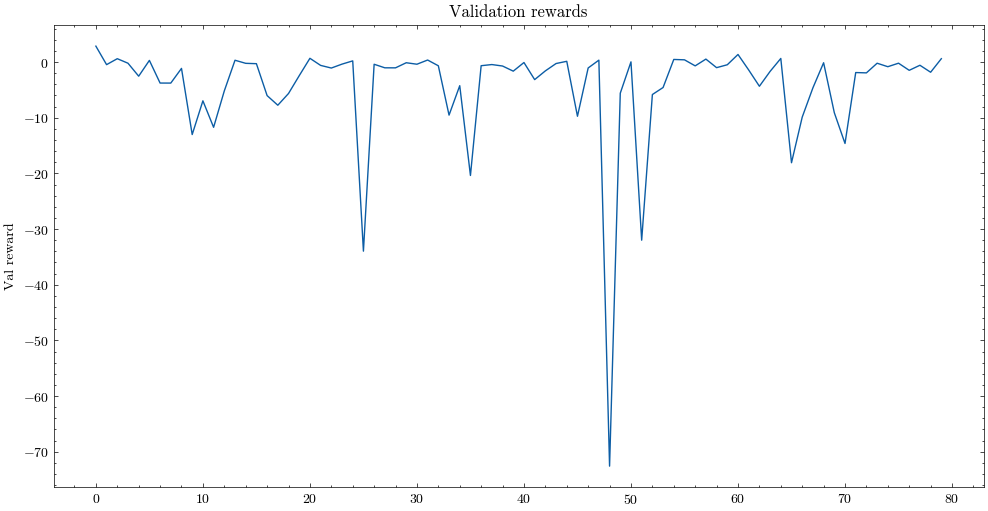

In [15]:
fig = plt.figure(figsize=(12, 6))

plt.plot(training_rewards)
plt.title('Validation rewards')
plt.ylabel('Val reward')
plt.show()

### Save the model

In [16]:
if SAVE:
    drive.mount('/content/drive')
    SAVE_MODEL_DIR = "/content/drive/MyDrive/Uni DK/Master's Thesis/Nets/"
    model.save(SAVE_MODEL_DIR + "td3-bs-zero")

Mounted at /content/drive


## Evaluation

In [22]:
test_env = BlackScholesEnvCont(init_s0, init_K, init_T, r, mu, init_vol, init_n_steps)
obs, info = test_env.reset(seed=SEED)

pp = pprint.PrettyPrinter(indent=4)
log_infos = False

rewards = []
hedges = []
bs_deltas = []
hedge_port = []
call_price = []

for i in range(252):
    action, _states = model.predict(obs)

    obs, reward, done, _, info = test_env.step(action)

    rewards.append(reward)
    hedges.append(action)
    bs_deltas.append(info['bs_delta'])
    hedge_port.append(info['hedge_portfolio_value'])
    call_price.append(info['price'])

    if log_infos:
        print(f'Step: {i}')
        print('Action:', action)
        print('Observations:')
        pp.pprint(obs)
        print('Infos')
        pp.pprint(info)
        print('Reward:', reward)

    if done:
        break

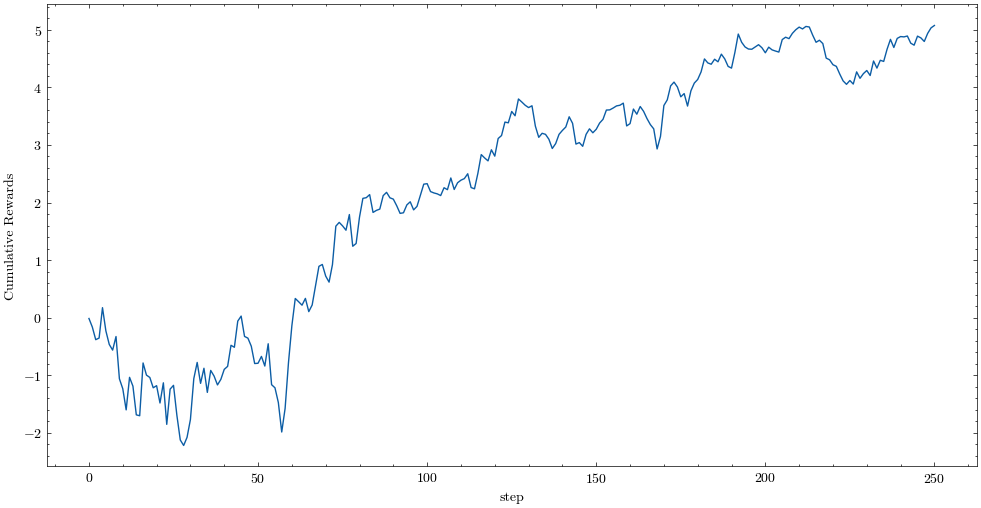

In [23]:
fig = plt.figure(figsize=(12, 6))

plt.plot(np.cumsum(rewards))
plt.xlabel('step')
plt.ylabel('Cumulative Rewards')
plt.show()

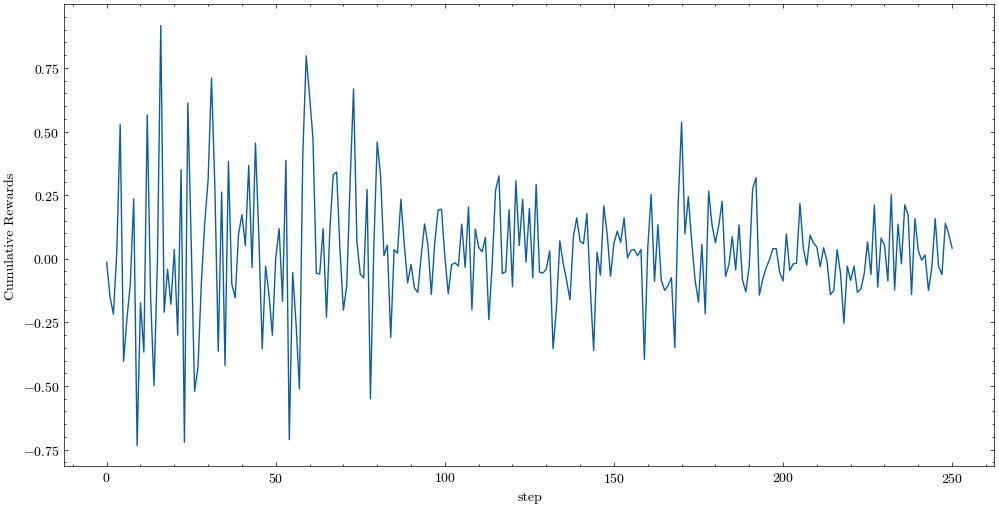

In [24]:
fig = plt.figure(figsize=(12, 6))

plt.plot(rewards)
plt.xlabel('step')
plt.ylabel('Cumulative Rewards')
plt.show()

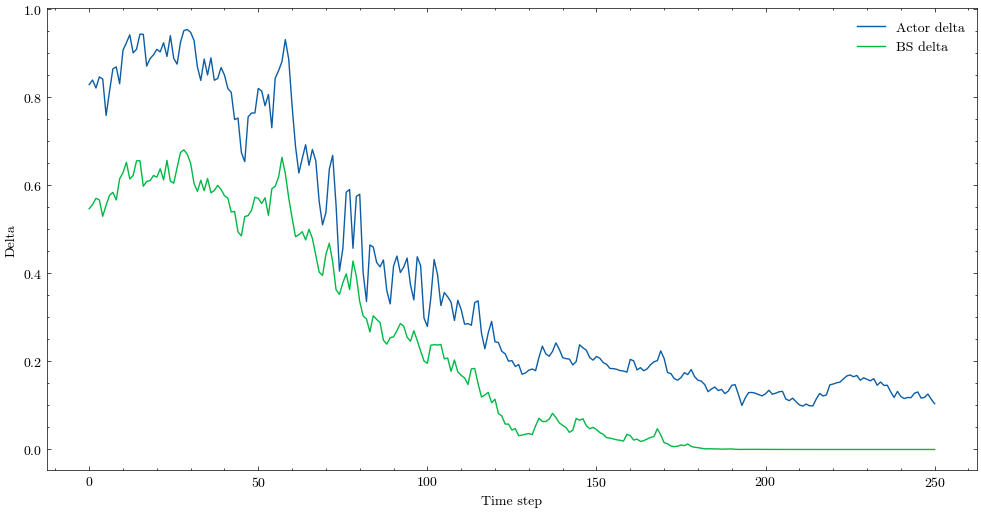

In [25]:
fig = plt.figure(figsize=(12, 6))

plt.plot(-np.array(hedges), label='Actor delta')
plt.plot(bs_deltas, label='BS delta')
plt.xlabel('Time step')
plt.ylabel('Delta')
plt.legend()
plt.show()

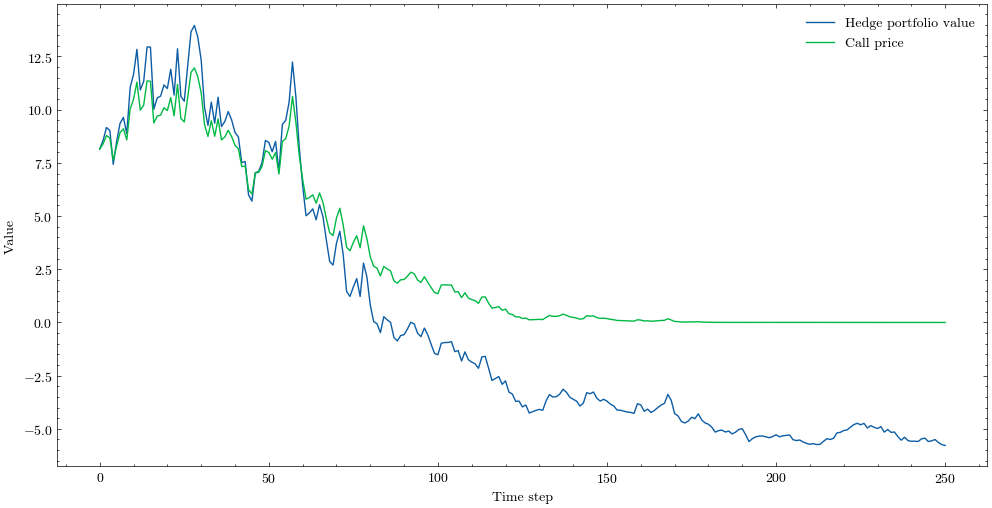

In [26]:
fig = plt.figure(figsize=(12, 6))

plt.plot(hedge_port, label='Hedge portfolio value')
plt.plot(call_price, label='Call price')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.show()